In [278]:
import numpy as np
import pandas as pd

data = pd.read_csv('emotions.csv')
data.head()

,# mean_0_a,mean_1_a,mean_2_a,mean_3_a,mean_4_a,mean_d_0_a,mean_d_1_a,mean_d_2_a,mean_d_3_a,mean_d_4_a,...,fft_741_b,fft_742_b,fft_743_b,fft_744_b,fft_745_b,fft_746_b,fft_747_b,fft_748_b,fft_749_b,label
0,4.62,30.3,-356.0,15.6,26.3,1.070,0.411,-15.70,2.06,3.15,...,23.5,20.3,20.3,23.5,-215.0,280.00,-162.00,-162.00,280.00,NEGATIVE
1,28.80,33.1,32.0,25.8,22.8,6.550,1.680,2.88,3.83,-4.82,...,-23.3,-21.8,-21.8,-23.3,182.0,2.57,-31.60,-31.60,2.57,NEUTRAL
2,8.90,29.4,-416.0,16.7,23.7,79.900,3.360,90.20,89.90,2.03,...,462.0,-233.0,-233.0,462.0,-267.0,281.00,-148.00,-148.00,281.00,POSITIVE
3,14.90,31.6,-143.0,19.8,24.3,-0.584,-0.284,8.82,2.30,-1.97,...,299.0,-243.0,-243.0,299.0,132.0,-12.40,9.53,9.53,-12.40,POSITIVE
4,28.30,31.3,45.2,27.3,24.5,34.800,-5.790,3.06,41.40,5.52,...,12.0,38.1,38.1,12.0,119.0,-17.60,23.90,23.90,-17.60,NEUTRAL


In [279]:

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


X = data.iloc[:, :-1].values
y = data['label'].values


label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [280]:

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2,stratify=y_encoded, random_state=42)

In [281]:
import pandas as pd


label_counts = data['label'].value_counts()

print("Label distribution before split:")
print(label_counts)

y_train_counts = pd.Series(y_train).value_counts()
y_test_counts = pd.Series(y_test).value_counts()

print("\nLabel distribution in training set:")
print(y_train_counts)

print("\nLabel distribution in test set:")
print(y_test_counts)

Label distribution before split:
NEUTRAL     716
NEGATIVE    708
POSITIVE    708
Name: label, dtype: int64

Label distribution in training set:
1    573
0    566
2    566
dtype: int64

Label distribution in test set:
1    143
2    142
0    142
dtype: int64


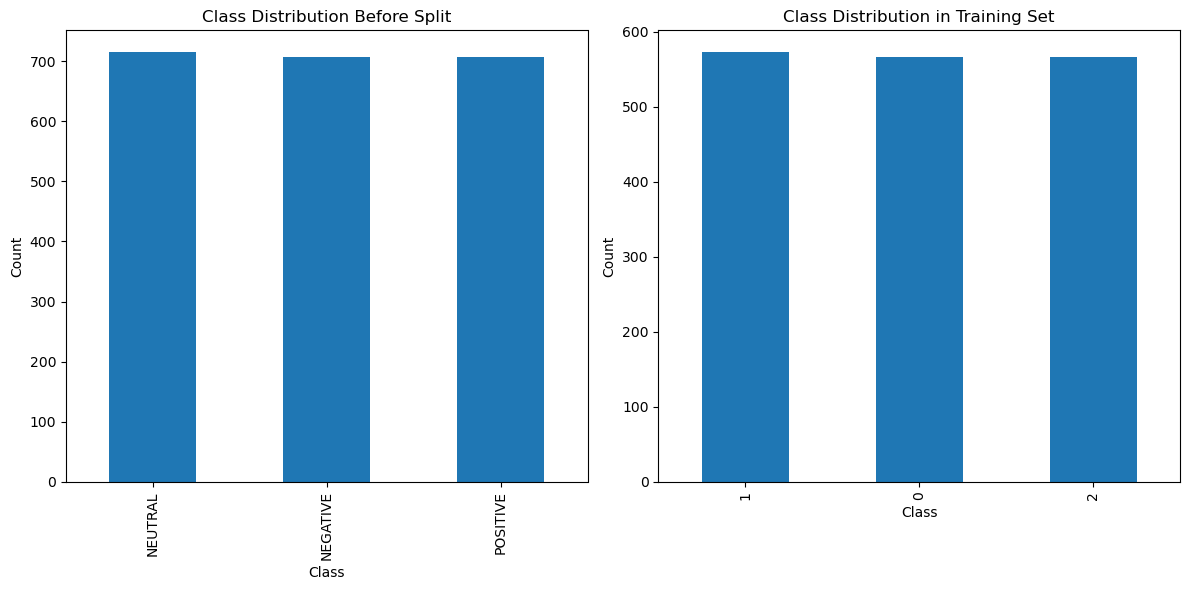

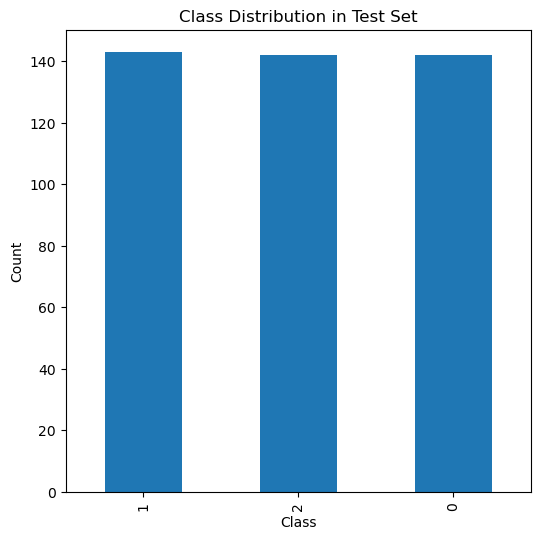

In [282]:
import pandas as pd
import matplotlib.pyplot as plt


y_train_series = pd.Series(y_train)
y_test_series = pd.Series(y_test)

df = pd.DataFrame({'target': y})
target_distribution_before = df['target'].value_counts()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
target_distribution_before.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution Before Split')

target_distribution_train = y_train_series.value_counts()

plt.subplot(1, 2, 2)
target_distribution_train.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution in Training Set')

plt.tight_layout()
plt.show()


target_distribution_test = y_test_series.value_counts()

plt.figure(figsize=(6, 6))
target_distribution_test.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution in Test Set')
plt.show()

In [283]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif # Changed from chi2 to f_classif
from sklearn.ensemble import RandomForestClassifier



k = 50  
selector = SelectKBest(score_func=f_classif, k=k) 
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

selected_indices = selector.get_support(indices=True)
print(f"Selected feature indices: {selected_indices}")


Selected feature indices: [   2   12   17   22   27   62  152  162  167  172  177  314  327  366
  374  375  444  447  555  558  570  573  885  888  930  933 1274 1276
 1286 1291 1296 1301 1336 1426 1436 1441 1446 1451 1588 1601 1640 1648
 1649 1718 1721 1802 1829 1832 2204 2207]


In [284]:


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

In [285]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping

input_dim = X_train_scaled.shape[1]

num_classes = 3  


model = Sequential()
model.add(Dense(128, input_dim=input_dim, activation='relu', kernel_regularizer=l2(0.01))) 
model.add(Dropout(0.5))  
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01))) 
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax')) 



from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 


early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train_scaled, y_train,
                    epochs=50,  
                    batch_size=32,  
                    validation_split=0.2,  
                    verbose=2,callbacks=[early_stopping])  


loss, accuracy = model.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")



from sklearn.metrics import classification_report, confusion_matrix


y_pred = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)


print("Classification Report:")
print(classification_report(y_test_classes, y_pred_classes))

print("Confusion Matrix:")
print(confusion_matrix(y_test_classes, y_pred_classes))

Epoch 1/50
43/43 - 2s - loss: 2.1192 - accuracy: 0.7339 - val_loss: 1.6749 - val_accuracy: 0.8739 - 2s/epoch - 41ms/step
Epoch 2/50
43/43 - 0s - loss: 1.6499 - accuracy: 0.8255 - val_loss: 1.4406 - val_accuracy: 0.8886 - 107ms/epoch - 2ms/step
Epoch 3/50
43/43 - 0s - loss: 1.4180 - accuracy: 0.8717 - val_loss: 1.2406 - val_accuracy: 0.9062 - 101ms/epoch - 2ms/step
Epoch 4/50
43/43 - 0s - loss: 1.2095 - accuracy: 0.8820 - val_loss: 1.0915 - val_accuracy: 0.9120 - 114ms/epoch - 3ms/step
Epoch 5/50
43/43 - 0s - loss: 1.0540 - accuracy: 0.8768 - val_loss: 0.9721 - val_accuracy: 0.9208 - 164ms/epoch - 4ms/step
Epoch 6/50
43/43 - 0s - loss: 0.9396 - accuracy: 0.8974 - val_loss: 0.8685 - val_accuracy: 0.9238 - 99ms/epoch - 2ms/step
Epoch 7/50
43/43 - 0s - loss: 0.8299 - accuracy: 0.9062 - val_loss: 0.7855 - val_accuracy: 0.9179 - 99ms/epoch - 2ms/step
Epoch 8/50
43/43 - 0s - loss: 0.7523 - accuracy: 0.8996 - val_loss: 0.7022 - val_accuracy: 0.9208 - 109ms/epoch - 3ms/step
Epoch 9/50
43/43 - 0

In [286]:
pip install keras-tuner


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [288]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from keras_tuner import RandomSearch
import numpy as np

def build_model(hp):
    model = Sequential()

    hp_units_1 = hp.Int('units_1', min_value=64, max_value=128, step=16)
    model.add(Dense(units=hp_units_1, activation='relu', input_dim=input_dim, kernel_regularizer=l2(hp.Float('l2_reg_1', min_value=0.001, max_value=0.1, step=0.001))))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.3, max_value=0.6, step=0.1)))
    

    hp_units_2 = hp.Int('units_2', min_value=32, max_value=64, step=16)
    model.add(Dense(units=hp_units_2, activation='relu', kernel_regularizer=l2(hp.Float('l2_reg_2', min_value=0.001, max_value=0.1, step=0.001))))
    model.add(Dropout(hp.Float('dropout_2', min_value=0.3, max_value=0.6, step=0.1)))
    
  
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop']),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model


tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=3,
    directory='my_dir',
    project_name='helloworld'
)


early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

tuner.search(X_train_scaled, y_train, epochs=50, validation_split=0.2, callbacks=[early_stopping])

best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best Hyperparameters: {best_hps.values}")

loss, accuracy = best_model.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


y_pred = best_model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)


from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report:")
print(classification_report(y_test_classes, y_pred_classes))

print("Confusion Matrix:")
print(confusion_matrix(y_test_classes, y_pred_classes))


Reloading Tuner from my_dir\helloworld\tuner0.json
Best Hyperparameters: {'units_1': 64, 'l2_reg_1': 0.012, 'dropout_1': 0.5, 'units_2': 32, 'l2_reg_2': 0.005, 'dropout_2': 0.3, 'optimizer': 'rmsprop'}
14/14 - 0s - loss: 0.3819 - accuracy: 0.9274 - 350ms/epoch - 25ms/step
Test Loss: 0.3819338381290436
Test Accuracy: 0.9274004697799683
14/14 [==============================] - 0s 2ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.99      0.92       142
           1       0.99      0.97      0.98       143
           2       0.94      0.83      0.88       142

    accuracy                           0.93       427
   macro avg       0.93      0.93      0.93       427
weighted avg       0.93      0.93      0.93       427

Confusion Matrix:
[[140   0   2]
 [  0 138   5]
 [ 22   2 118]]


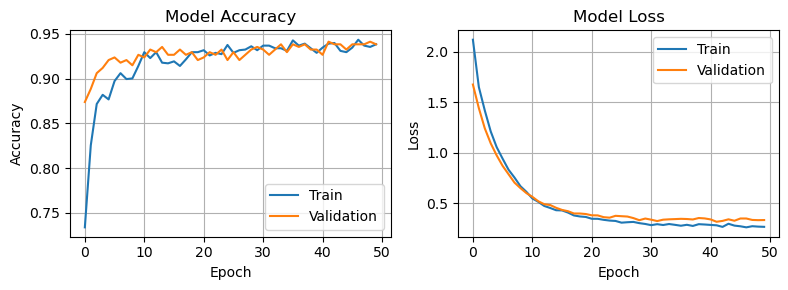

In [289]:
import matplotlib.pyplot as plt


plt.figure(figsize=(8,3))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.grid(True)

plt.tight_layout()
plt.show()


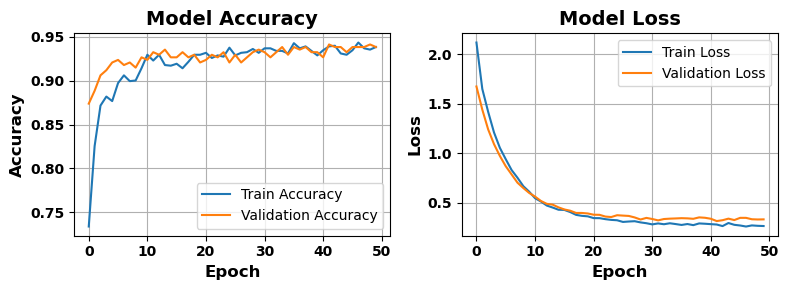

In [290]:
import matplotlib.pyplot as plt


plt.figure(figsize=(8, 3))


plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12, fontweight='bold')
plt.ylabel('Accuracy', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True)
plt.xticks(fontsize=10, fontweight='bold')
plt.yticks(fontsize=10, fontweight='bold')


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12, fontweight='bold')
plt.ylabel('Loss', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True)
plt.xticks(fontsize=10, fontweight='bold')
plt.yticks(fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()


14/14 [==============================] - 0s 2ms/step


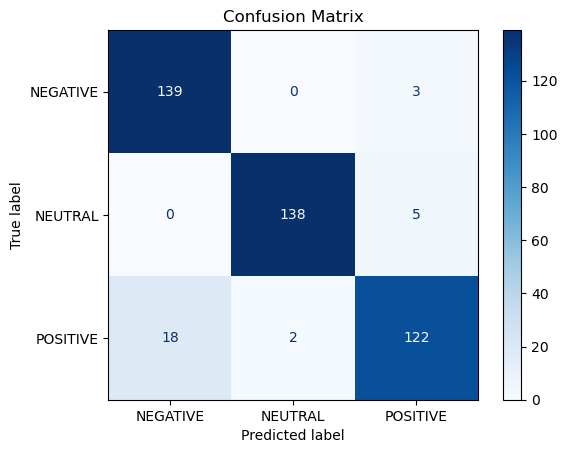

In [291]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


y_pred = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)


cm = confusion_matrix(y_test_classes, y_pred_classes)


disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')
plt.show()


In [292]:
pip install alibi


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [261]:
pip install visualkeras


Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
     -------------------------------------- 45.0/45.0 kB 551.0 kB/s eta 0:00:00


In [293]:
import visualkeras

In [294]:

visualkeras.layered_view(model, to_file='model.png')

C:\Users\Sanju\AppData\Roaming\Python\Python310\site-packages\visualkeras\layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


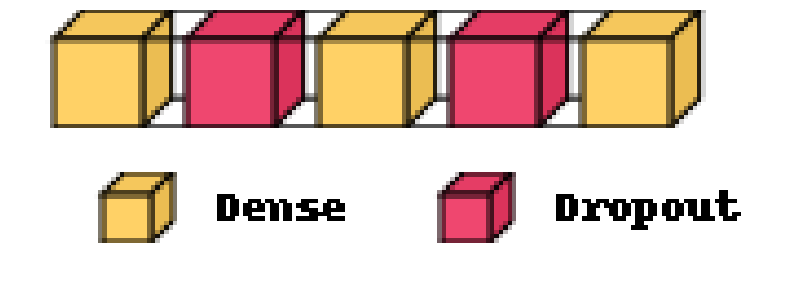

In [295]:
import visualkeras
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO


img = visualkeras.layered_view(model, legend=True)

img_byte_arr = BytesIO()
img.save(img_byte_arr, format='PNG')


img_byte_arr.seek(0)  
img = Image.open(img_byte_arr)


plt.figure(figsize=(10, 5))
plt.imshow(img)
plt.axis('off')  
plt.show()
